In [1]:
'''
TORCWA Example1-1
Multi-layered meta-atom

'''
# Import
import numpy as np
import torch
from matplotlib import pyplot as plt
import scipy.io

import torcwa
import Materials

# Hardware
# If GPU support TF32 tensor core, the matmul operation is faster than FP32 but with less precision.
# If you need accurate operation, you have to disable the flag below.
torch.backends.cuda.matmul.allow_tf32 = False
sim_dtype = torch.complex64
geo_dtype = torch.float32
device = torch.device('cuda')

# Simulation environment
# light
lamb0 = torch.tensor(650.,dtype=geo_dtype,device=device)    # nm
inc_ang = 0.*(np.pi/180)    # radian
azi_ang = 0.*(np.pi/180)    # radian

# material
substrate_eps = 1.46**2
SU8_eps = 1.6**2

# geometry
L = [300., 300.]            # nm / nm
torcwa.rcwa_geo.dtype = geo_dtype
torcwa.rcwa_geo.device = device
torcwa.rcwa_geo.Lx = L[0]
torcwa.rcwa_geo.Ly = L[1]
torcwa.rcwa_geo.nx = 300
torcwa.rcwa_geo.ny = 300
torcwa.rcwa_geo.grid()
torcwa.rcwa_geo.edge_sharpness = 1000.
z = torch.linspace(-500,1500,501,device=device)

x_axis = torcwa.rcwa_geo.x.cpu()
y_axis = torcwa.rcwa_geo.y.cpu()
z_axis = z.cpu()

# layers
Wx, Wy = 180, 100
layer0_geometry = torcwa.rcwa_geo.rectangle(Wx=Wx,Wy=Wy,Cx=L[0]/2.,Cy=L[1]/2.,theta=0)
layer0_thickness = 200.
layer1_thickness = 100.
layer2_geometry = torcwa.rcwa_geo.rectangle(Wx=Wx,Wy=Wy,Cx=L[0]/2.,Cy=L[1]/2.,theta=30/180*np.pi)
layer2_thickness = 200.
layer3_thickness = 100.
layer4_geometry = torcwa.rcwa_geo.rectangle(Wx=Wx,Wy=Wy,Cx=L[0]/2.,Cy=L[1]/2.,theta=60/180*np.pi)
layer4_thickness = 200.
layer5_thickness = 100.

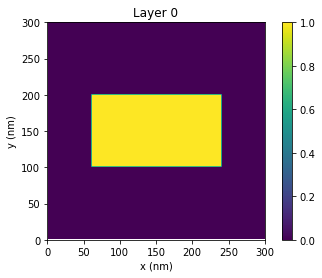

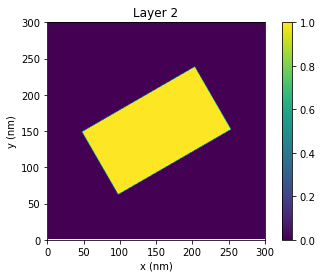

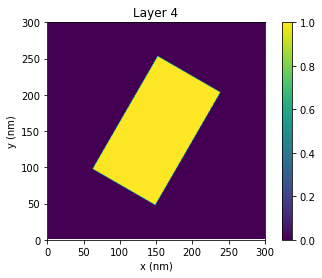

In [2]:
# View layers
plt.figure(1)
plt.imshow(torch.transpose(layer0_geometry,-2,-1).cpu(),origin='lower',extent=[x_axis[0],x_axis[-1],y_axis[0],y_axis[-1]])
plt.title('Layer 0')
plt.xlim([0,L[0]])
plt.xlabel('x (nm)')
plt.ylim([0,L[1]])
plt.ylabel('y (nm)')
plt.colorbar()

plt.figure(2)
plt.imshow(torch.transpose(layer2_geometry,-2,-1).cpu(),origin='lower',extent=[x_axis[0],x_axis[-1],y_axis[0],y_axis[-1]])
plt.title('Layer 2')
plt.xlim([0,L[0]])
plt.xlabel('x (nm)')
plt.ylim([0,L[1]])
plt.ylabel('y (nm)')
plt.colorbar()

plt.figure(3)
plt.imshow(torch.transpose(layer4_geometry,-2,-1).cpu(),origin='lower',extent=[x_axis[0],x_axis[-1],y_axis[0],y_axis[-1]])
plt.title('Layer 4')
plt.xlim([0,L[0]])
plt.xlabel('x (nm)')
plt.ylim([0,L[1]])
plt.ylabel('y (nm)')
plt.colorbar()

In [3]:
# Generate and perform simulation
for order_N in range(23):
    order = [order_N,order_N]

    sim = torcwa.rcwa(freq=1/lamb0,order=order,L=L,dtype=sim_dtype,device=device)
    sim.add_input_layer(eps=substrate_eps)
    sim.set_incident_angle(inc_ang=inc_ang,azi_ang=azi_ang)
    silicon_eps = Materials.aSiH.apply(lamb0)**2
    layer0_eps = layer0_geometry*silicon_eps + (1.-layer0_geometry)*SU8_eps
    layer2_eps = layer2_geometry*silicon_eps + (1.-layer2_geometry)*SU8_eps
    layer4_eps = layer4_geometry*silicon_eps + (1.-layer4_geometry)*SU8_eps

    sim.add_layer(thickness=layer0_thickness,eps=layer0_eps)
    sim.add_layer(thickness=layer1_thickness,eps=SU8_eps)
    sim.add_layer(thickness=layer2_thickness,eps=layer2_eps)
    sim.add_layer(thickness=layer3_thickness,eps=SU8_eps)
    sim.add_layer(thickness=layer4_thickness,eps=layer4_eps)
    sim.add_layer(thickness=layer5_thickness,eps=SU8_eps)

    sim.solve_global_smatrix()

    txx = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    tyx = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])
    txy = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    tyy = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])

    TRR = (torch.abs(txx+tyy+1.j*(txy-tyx))/2) ** 2
    TLR = (torch.abs(txx-tyy+1.j*(txy+tyx))/2) ** 2
    TRL = (torch.abs(txx-tyy-1.j*(txy+tyx))/2) ** 2
    TLL = (torch.abs(txx+tyy-1.j*(txy-tyx))/2) ** 2

    ex1_1_data = {'txx':txx.cpu().numpy(),'tyx':tyx.cpu().numpy(),'txy':txy.cpu().numpy(),'tyy':tyy.cpu().numpy(),
        'TRR':TRR.cpu().numpy(),'TLR':TLR.cpu().numpy(),'TRL':TRL.cpu().numpy(),'TLL':TLL.cpu().numpy()}
    scipy.io.savemat('Example1-1_data_order_'+str(order_N)+'.mat',ex1_1_data)

In [4]:
# Generate and perform simulation
lamb0 = torch.tensor(650.,dtype=geo_dtype,device=device)    # nm

order_N = 15
order = [order_N,order_N]
sim = torcwa.rcwa(freq=1/lamb0,order=order,L=L,dtype=sim_dtype,device=device)
sim.add_input_layer(eps=substrate_eps)
sim.set_incident_angle(inc_ang=inc_ang,azi_ang=azi_ang)
silicon_eps = Materials.aSiH.apply(lamb0)**2
layer0_eps = layer0_geometry*silicon_eps + (1.-layer0_geometry)*SU8_eps
layer2_eps = layer2_geometry*silicon_eps + (1.-layer2_geometry)*SU8_eps
layer4_eps = layer4_geometry*silicon_eps + (1.-layer4_geometry)*SU8_eps
sim.add_layer(thickness=layer0_thickness,eps=layer0_eps)
sim.add_layer(thickness=layer1_thickness,eps=SU8_eps)
sim.add_layer(thickness=layer2_thickness,eps=layer2_eps)
sim.add_layer(thickness=layer3_thickness,eps=SU8_eps)
sim.add_layer(thickness=layer4_thickness,eps=layer4_eps)
sim.add_layer(thickness=layer5_thickness,eps=SU8_eps)
sim.solve_global_smatrix()

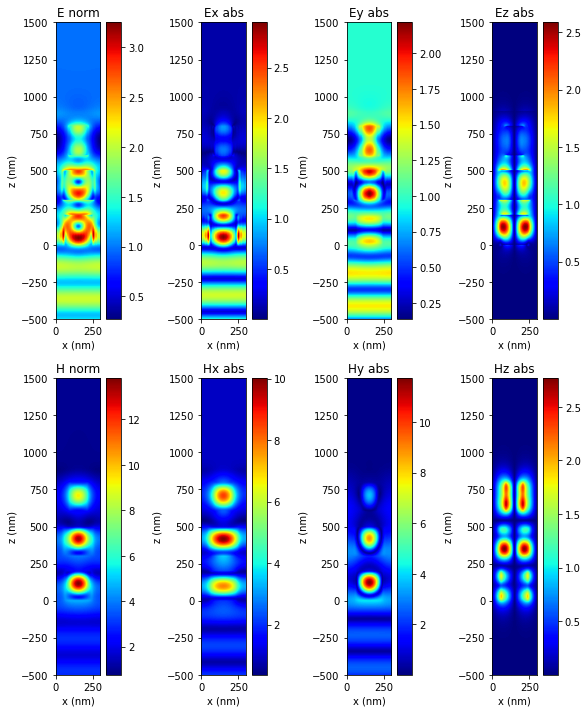

In [5]:
# View XZ-plane fields and export
sim.source_planewave(amplitude=[1.,1.j],direction='forward')

[Ex, Ey, Ez], [Hx, Hy, Hz] = sim.field_xz(torcwa.rcwa_geo.x,z,L[1]/2)
Enorm = torch.sqrt(torch.abs(Ex)**2 + torch.abs(Ey)**2 + torch.abs(Ez)**2)
Hnorm = torch.sqrt(torch.abs(Hx)**2 + torch.abs(Hy)**2 + torch.abs(Hz)**2)

fig, axes = plt.subplots(figsize=(10,12),nrows=2,ncols=4)
im0 = axes[0,0].imshow(torch.transpose(Enorm,-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
axes[0,0].set(title='E norm',xlim=(0,L[0]),xlabel='x (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im1 = axes[0,1].imshow(torch.transpose(torch.abs(Ex),-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
axes[0,1].set(title='Ex abs',xlim=(0,L[0]),xlabel='x (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im2 = axes[0,2].imshow(torch.transpose(torch.abs(Ey),-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
axes[0,2].set(title='Ey abs',xlim=(0,L[0]),xlabel='x (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im3 = axes[0,3].imshow(torch.transpose(torch.abs(Ez),-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
axes[0,3].set(title='Ez abs',xlim=(0,L[0]),xlabel='x (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im4 = axes[1,0].imshow(torch.transpose(Hnorm,-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
axes[1,0].set(title='H norm',xlim=(0,L[0]),xlabel='x (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im5 = axes[1,1].imshow(torch.transpose(torch.abs(Hx),-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
axes[1,1].set(title='Hx abs',xlim=(0,L[0]),xlabel='x (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im6 = axes[1,2].imshow(torch.transpose(torch.abs(Hy),-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
axes[1,2].set(title='Hy abs',xlim=(0,L[0]),xlabel='x (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im7 = axes[1,3].imshow(torch.transpose(torch.abs(Hz),-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
axes[1,3].set(title='Hz abs',xlim=(0,L[0]),xlabel='x (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
fig.colorbar(im0,ax=axes[0,0])
fig.colorbar(im1,ax=axes[0,1])
fig.colorbar(im2,ax=axes[0,2])
fig.colorbar(im3,ax=axes[0,3])
fig.colorbar(im4,ax=axes[1,0])
fig.colorbar(im5,ax=axes[1,1])
fig.colorbar(im6,ax=axes[1,2])
fig.colorbar(im7,ax=axes[1,3])